# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
import numpy as np

p1 = 8 / 10
p2 = 2 / 10

entropy = - (p1 * np.log(p1) + p2 * np.log(p2))
round(entropy, 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
p1_m = 8 / 10
p2_m = 2 / 10

# Индекс Джини для исходного множества R_m
H_Rm = p1_m * (1 - p1_m) + p2_m * (1 - p2_m)

H_Rl = 0
H_Rr = 0

# Размеры поддеревьев
R_l_size = 8
R_r_size = 2
R_m_size = 10

# Критерий информативности
Q = H_Rm - (R_l_size / R_m_size) * H_Rl - (R_r_size / R_m_size) * H_Rr
round(Q, 2)


0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
values = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

mean_value = np.mean(values)
mean_value

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [14]:
def calculate_gini(target_vector):
    _, counts = np.unique(target_vector, return_counts=True)
    probabilities = counts / len(target_vector)
    return np.sum(probabilities * (1 - probabilities))

def calculate_variance(target_vector):
    return np.var(target_vector)

def find_best_split(feature_vector, target_vector, task="classification", feature_type="real"):
    unique_values = np.unique(feature_vector)

    if feature_type == "real":
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2
    else:
        thresholds = unique_values

    best_threshold = None
    best_gain = -np.inf

    if task == "classification":
        base_criterion = calculate_gini(target_vector)
    else:
        base_criterion = calculate_variance(target_vector)

    gains = []

    for threshold in thresholds:
        if feature_type == "real":
            left_indices = feature_vector < threshold
            right_indices = feature_vector >= threshold
        else:
            left_indices = feature_vector == threshold
            right_indices = feature_vector != threshold

        if left_indices.sum() == 0 or right_indices.sum() == 0:
            continue

        left_target = target_vector[left_indices]
        right_target = target_vector[right_indices]

        if task == "classification":
            left_criterion = calculate_gini(left_target)
            right_criterion = calculate_gini(right_target)
        else:
            left_criterion = calculate_variance(left_target)
            right_criterion = calculate_variance(right_target)

        gain = base_criterion - (left_indices.mean() * left_criterion + right_indices.mean() * right_criterion)
        gains.append(gain)

        if gain > best_gain:
            best_gain = gain
            best_threshold = threshold

    return thresholds, gains, best_threshold, best_gain


Эту функцию можно протестировать на датасете `California`.

In [15]:
from sklearn.datasets import fetch_california_housing
import warnings # import to ignore HTTP 403 error fetch_california_housing
warnings.filterwarnings("ignore") # import to ignore HTTP 403 error fetch_california_housing


In [16]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [17]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

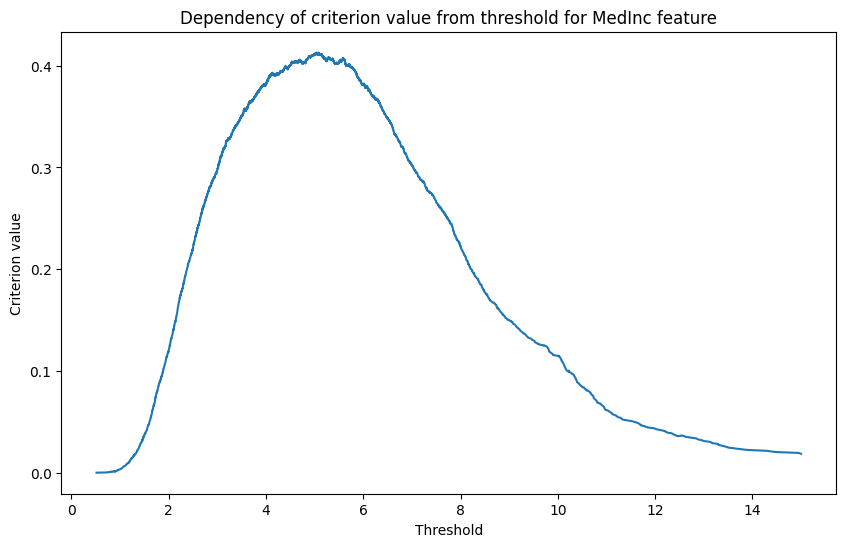

In [18]:
thresholds, gains, _, _ = find_best_split(X['MedInc'].values, y, task="regression")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, gains)
plt.xlabel('Threshold')
plt.ylabel('Criterion value')
plt.title('Dependency of criterion value from threshold for MedInc feature')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [21]:
best_threshold, best_gain = find_best_split(X['MedInc'].values, y, task="regression")[-2:]
print(f"Best Threshold: {best_threshold}, Best Gain: {best_gain}")


Best Threshold: 5.03515, Best Gain: 0.41275138620167695


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [22]:
from collections import Counter
from typing import Dict, List, Union

class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева
        self._tree = {}

        # Типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # Гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict,
        depth: int = 0
    ) -> None:
        # Критерий останова
        if np.all(sub_y == sub_y[0]) or (self._max_depth is not None and depth >= self._max_depth):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            # Подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            # Ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # Записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]

        feature_split = node["feature_split"]

        if self._feature_types[feature_split] == "real":
            if x[feature_split] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_split] == "categorical":
            if x[feature_split] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [25]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv

--2024-05-23 13:22:09--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7794 (7.6K) [text/plain]
Saving to: ‘students.csv’

students.csv        100%[===================>]   7.61K  --.-KB/s    in 0.001s  

2024-05-23 13:22:09 (12.2 MB/s) - ‘students.csv’ saved [7794/7794]



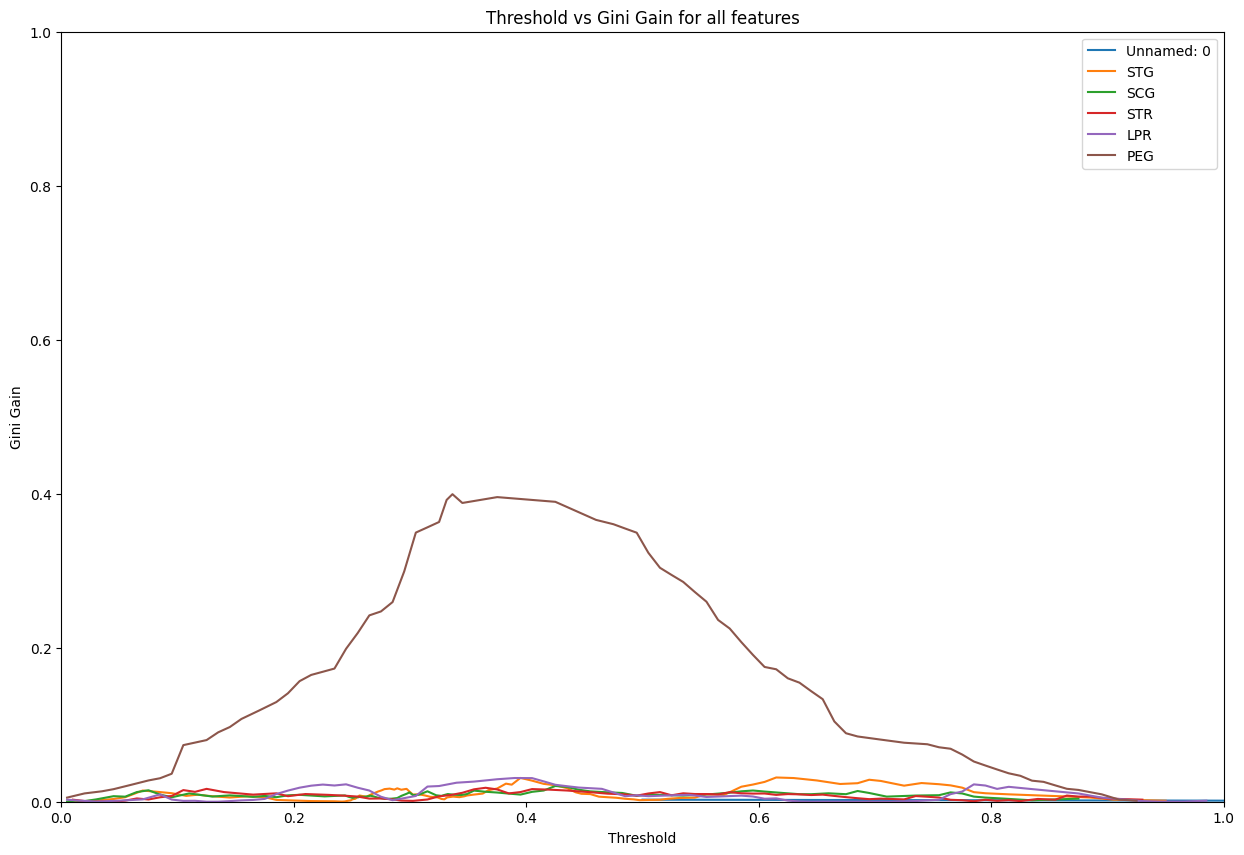

In [41]:
df = pd.read_csv('students.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
feature_names = df.columns[:-1]
plt.figure(figsize=(15, 10))
for i, feature_name in enumerate(feature_names):
    feature_vector = X[:, i]
    thresholds, gains, _, _ = find_best_split(feature_vector, y, task="classification", feature_type="real")
    plt.plot(thresholds, gains, label=feature_name)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Threshold')
plt.ylabel('Gini Gain')
plt.title('Threshold vs Gini Gain for all features')
plt.legend()
plt.show()

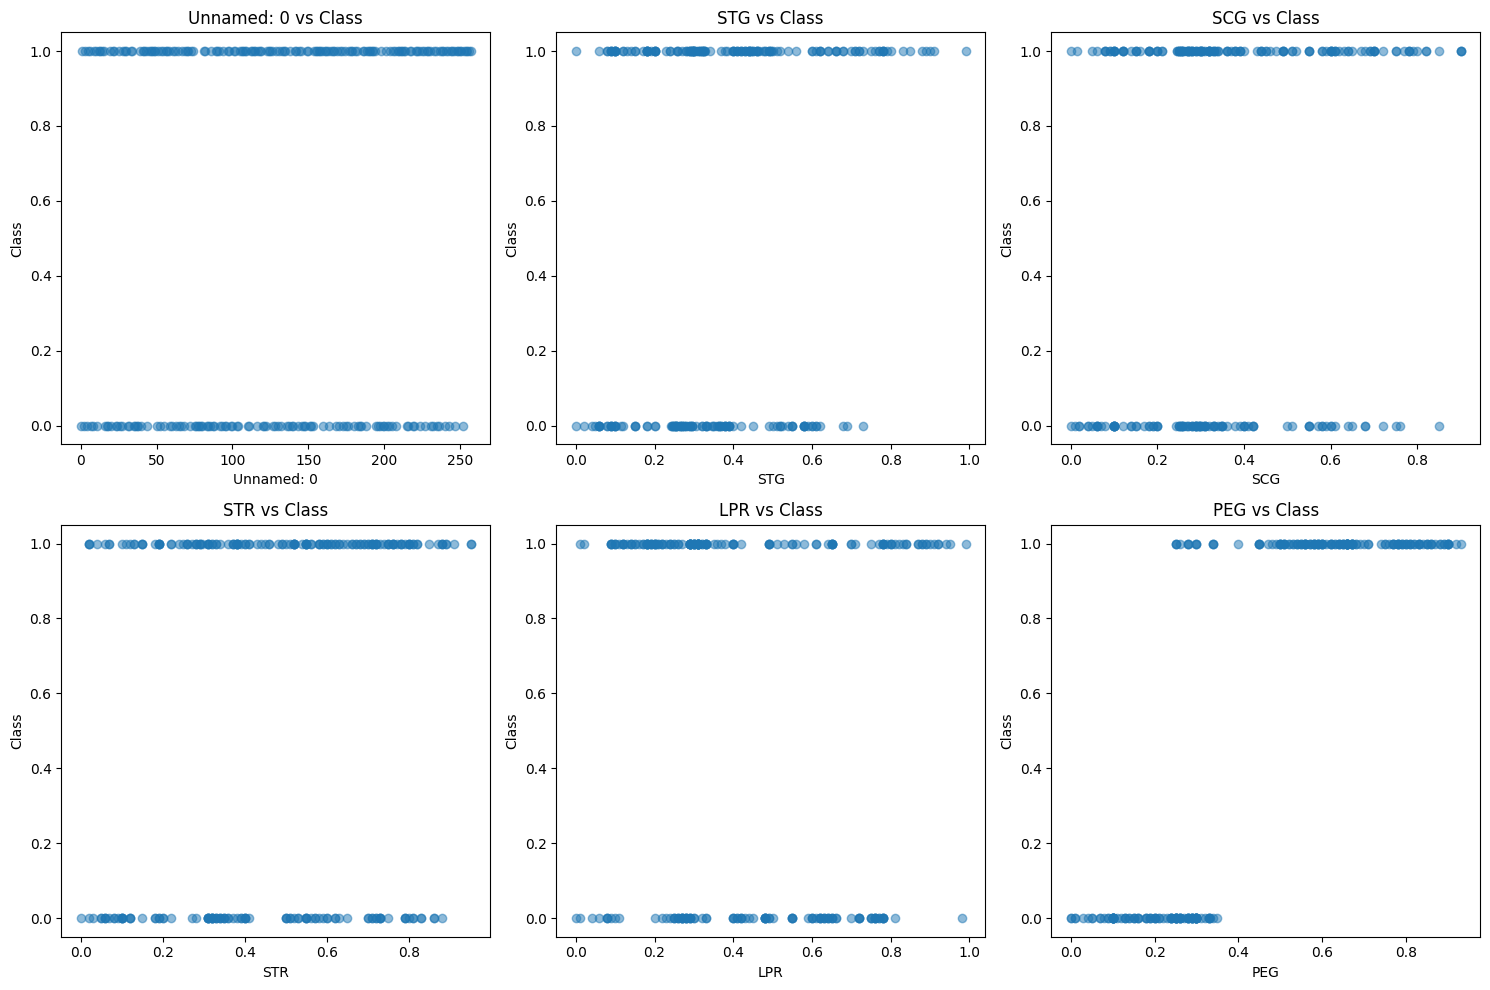

In [42]:
plt.figure(figsize=(15, 10))
for i, feature_name in enumerate(feature_names):
    plt.subplot(2, 3, i+1)
    plt.scatter(X[:, i], y, alpha=0.5)
    plt.xlabel(feature_name)
    plt.ylabel('Class')
    plt.title(f'{feature_name} vs Class')

plt.tight_layout()
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [ ]:
Самое лучшее - PEG, это видно и по диаграмме рассеяния, которая хорошо разделяет классы. Самые плохие кривые, это кривые, которые схожи наклонной кривой (k=1) и проходящие через начало координат


**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [43]:
!wget https://archive.ics.uci.edu/static/public/73/mushroom.zip
!unzip mushroom.zip

--2024-05-23 13:32:08--  https://archive.ics.uci.edu/static/public/73/mushroom.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘mushroom.zip’

mushroom.zip            [  <=>               ] 138.01K   556KB/s    in 0.2s    

2024-05-23 13:32:08 (556 KB/s) - ‘mushroom.zip’ saved [141318]

Archive:  mushroom.zip
  inflating: Index                   
  inflating: README                  
  inflating: agaricus-lepiota.data   
  inflating: agaricus-lepiota.names  
  inflating: expanded.Z              


In [48]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

data = pd.read_csv('agaricus-lepiota.data', header=None)
label_encoder = LabelEncoder()

for column in data.columns:
    data[column] = label_encoder.fit_transform(data[column])

features = data.iloc[:, 1:]
target = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

predictions = decision_tree.predict(X_test)
model_accuracy = accuracy_score(y_test, predictions)
print('Модельная точность:', model_accuracy)


Модельная точность: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [49]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [51]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv

--2024-05-23 13:38:00--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23105 (23K) [text/plain]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2024-05-23 13:38:00 (15.0 MB/s) - ‘diabetes.csv’ saved [23105/23105]



In [52]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

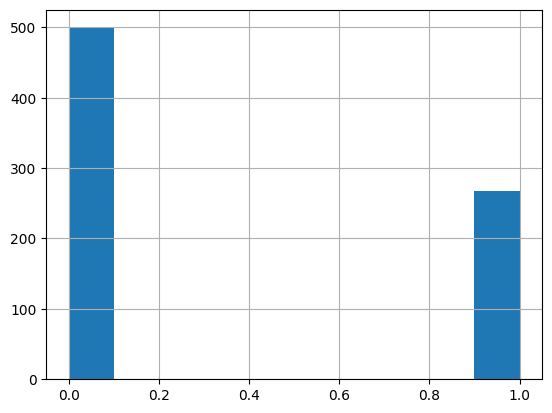

In [53]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [54]:
X = data.drop(columns='Outcome')
y = data['Outcome']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")

Training set shape: (375, 8), Validation set shape: (162, 8), Test set shape: (231, 8)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [65]:
from sklearn.metrics import f1_score

max_depth_values = [3, 5, 7, 10, 12, 15, 20]
min_samples_leaf_values = [1, 2, 5, 10, 15, 20]

best_f1_score = 0
best_params = {'max_depth': None, 'min_samples_leaf': None}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)

        y_val_pred = clf.predict(X_val)

        current_f1_score = f1_score(y_val, y_val_pred)

        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_params['max_depth'] = max_depth
            best_params['min_samples_leaf'] = min_samples_leaf

print(f"Лучшие параметры: max_depth={best_params['max_depth']}, min_samples_leaf={best_params['min_samples_leaf']}")
print(f"Лучшее значение F1-меры на валидационной выборке: {best_f1_score}")

best_clf = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=42)
best_clf.fit(X_train_full, y_train_full)

y_test_pred = best_clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

print(f"Точность (accuracy): {test_accuracy}")
print(f"Точность (precision): {test_precision}")
print(f"Полнота (recall): {test_recall}")
print(f"AUC-ROC: {test_roc_auc}")


Лучшие параметры: max_depth=5, min_samples_leaf=20
Лучшее значение F1-меры на валидационной выборке: 0.625
Точность (accuracy): 0.7272727272727273
Точность (precision): 0.6451612903225806
Полнота (recall): 0.49382716049382713
AUC-ROC: 0.6735802469135802


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [59]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train_full, y_train_full)

y_test_pred_bagging = bagging_clf.predict(X_test)

bagging_accuracy = accuracy_score(y_test, y_test_pred_bagging)
bagging_precision = precision_score(y_test, y_test_pred_bagging)
bagging_recall = recall_score(y_test, y_test_pred_bagging)
bagging_roc_auc = roc_auc_score(y_test, y_test_pred_bagging)

print(f"Bagging Classifier - Точность (accuracy): {bagging_accuracy}")
print(f"Bagging Classifier - Точность (precision): {bagging_precision}")
print(f"Bagging Classifier - Полнота (recall): {bagging_recall}")
print(f"Bagging Classifier - AUC-ROC: {bagging_roc_auc}")

Bagging Classifier - Точность (accuracy): 0.7532467532467533
Bagging Classifier - Точность (precision): 0.6875
Bagging Classifier - Полнота (recall): 0.5432098765432098
Bagging Classifier - AUC-ROC: 0.7049382716049383


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

max_depth_values = [3, 5, 7, 10, 12, 15, 20]
min_samples_split_values = [2, 5, 10, 15, 20]

best_f1_score = 0
best_params = {'max_depth': None, 'min_samples_split': None}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf_clf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)

        f1_scores = cross_val_score(rf_clf, X_train_full, y_train_full, cv=5, scoring='f1')

        mean_f1_score = np.mean(f1_scores)

        if mean_f1_score > best_f1_score:
            best_f1_score = mean_f1_score
            best_params['max_depth'] = max_depth
            best_params['min_samples_split'] = min_samples_split

print(f"Лучшие параметры: max_depth={best_params['max_depth']}, min_samples_split={best_params['min_samples_split']}")
print(f"Лучшее среднее значение F1-меры: {best_f1_score}")

best_rf_clf = RandomForestClassifier(n_estimators=50, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)
best_rf_clf.fit(X_train_full, y_train_full)

y_test_pred_rf = best_rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_precision = precision_score(y_test, y_test_pred_rf)
rf_recall = recall_score(y_test, y_test_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_test_pred_rf)

print(f"Random Forest - Точность (accuracy): {rf_accuracy}")
print(f"Random Forest - Точность (precision): {rf_precision}")
print(f"Random Forest - Полнота (recall): {rf_recall}")
print(f"Random Forest - AUC-ROC: {rf_roc_auc}")

print("\nСравнение моделей:")
print(f"Decision Tree - Точность (accuracy): {test_accuracy}, Точность (precision): {test_precision}, Полнота (recall): {test_recall}, AUC-ROC: {test_roc_auc}")
print(f"Bagging Classifier - Точность (accuracy): {bagging_accuracy}, Точность (precision): {bagging_precision}, Полнота (recall): {bagging_recall}, AUC-ROC: {bagging_roc_auc}")
print(f"Random Forest - Точность (accuracy): {rf_accuracy}, Точность (precision): {rf_precision}, Полнота (recall): {rf_recall}, AUC-ROC: {rf_roc_auc}")


Лучшие параметры: max_depth=20, min_samples_split=10
Лучшее среднее значение F1-меры: 0.6334310134310134
Random Forest - Точность (accuracy): 0.7402597402597403
Random Forest - Точность (precision): 0.6567164179104478
Random Forest - Полнота (recall): 0.5432098765432098
Random Forest - AUC-ROC: 0.6949382716049384

Сравнение моделей:
Decision Tree - Точность (accuracy): 0.7272727272727273, Точность (precision): 0.6451612903225806, Полнота (recall): 0.49382716049382713, AUC-ROC: 0.6735802469135802
Bagging Classifier - Точность (accuracy): 0.7532467532467533, Точность (precision): 0.6875, Полнота (recall): 0.5432098765432098, AUC-ROC: 0.7049382716049383
Random Forest - Точность (accuracy): 0.7402597402597403, Точность (precision): 0.6567164179104478, Полнота (recall): 0.5432098765432098, AUC-ROC: 0.6949382716049384


Как видим, лучшая модель вторая, по всем показателям

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

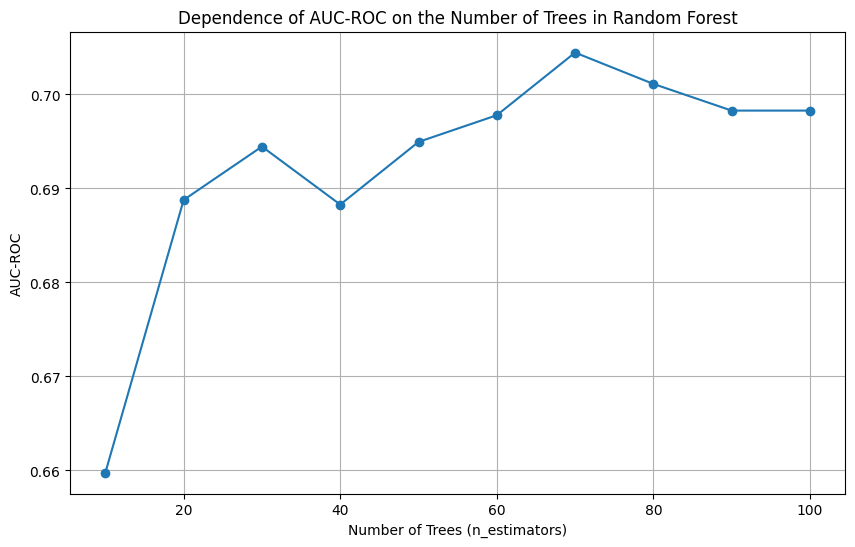

In [62]:
n_estimators_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
auc_scores = []
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']

for n_estimators in n_estimators_values:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
    rf_clf.fit(X_train_full, y_train_full)

    y_test_pred_rf = rf_clf.predict(X_test)

    rf_roc_auc = roc_auc_score(y_test, y_test_pred_rf)
    auc_scores.append(rf_roc_auc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, auc_scores, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('AUC-ROC')
plt.title('Dependence of AUC-ROC on the Number of Trees in Random Forest')
plt.grid(True)
plt.show()

Как правило, с увеличением числа деревьев в случайном лесе качество модели (оцененное с помощью AUC-ROC) увеличивается
Начиная с определенного количества деревьев, прирост в качестве может становиться менее значительным или даже переставать улучшаться. Это связано с тем, что случайный лес становится более устойчивым к переобучению, и увеличение числа деревьев перестает давать значительный прирост в производительности модели
График помогает определить оптимальное количество деревьев, при котором модель достигает наилучшего качества, что позволяет избежать избыточных вычислительных затрат на обучение слишком большого числа деревьев

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

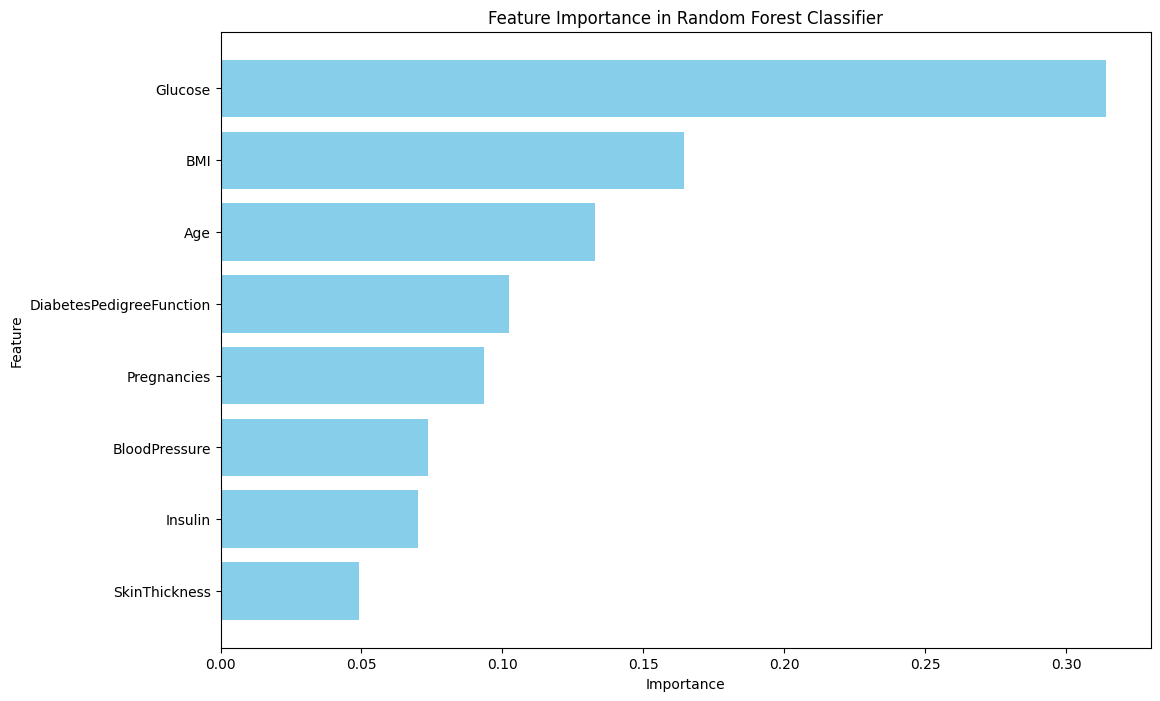

Самый важный признак для определения диабета: Glucose с важностью 0.3142


In [64]:
best_rf_clf.fit(X_train_full, y_train_full)

feature_importances = best_rf_clf.feature_importances_
features = X_train_full.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

most_important_feature = importance_df.iloc[0]
print(f"Самый важный признак для определения диабета: {most_important_feature['Feature']} с важностью {most_important_feature['Importance']:.4f}")
